# Image classification and regression

## Given code

In [270]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm_notebook

from keras.layers import Conv2D, MaxPool2D, Flatten, Reshape, Dropout, Dense, UpSampling2D, MaxPooling2D, Input, Merge
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
import keras.utils as np_utils

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


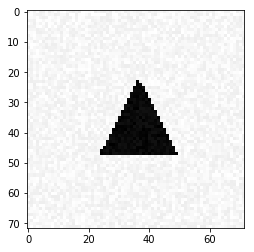

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [4]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in tqdm_notebook(range(nb_samples)):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in tqdm_notebook(range(nb_samples)):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple classification

We build the dataset

In [5]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_dataset_classification(100, 20)

Creating data:



Creating data:


We build the model:

In [6]:
from keras.models import Sequential
from keras.layers import Dense

nb_classes = 3

model = Sequential([
    Dense(nb_classes, input_shape=((X_train.shape[1],)),activation="softmax")
])

*Y_train* is a list of integers containing the id of the class for each sample. We need a list of one-hot encoding vectors for the classes. 

In [7]:
Y_train_bis = np_utils.to_categorical(Y_train)
Y_test_bis = np_utils.to_categorical(Y_test)

### With SGD

In [8]:
sgd = SGD(lr=0.001, decay=1e-8, momentum=0.9, nesterov=True)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=sgd,
    metrics=["accuracy"]
)

In [9]:
model.fit(X_train, Y_train_bis, 
          validation_data=(X_test, Y_test_bis),
          epochs=20, batch_size=32, verbose=1)

Train on 300 samples, validate on 100 samples
Epoch 1/20
300/300 [==============================] - 0s - loss: 1.1886 - acc: 0.3733 - val_loss: 1.2607 - val_acc: 0.5800
Epoch 2/20
300/300 [==============================] - 0s - loss: 0.7505 - acc: 0.6900 - val_loss: 0.6300 - val_acc: 0.7600
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.5285 - acc: 0.7867 - val_loss: 0.4069 - val_acc: 0.9000
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.4056 - acc: 0.8600 - val_loss: 0.3228 - val_acc: 0.9400
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.3172 - acc: 0.9133 - val_loss: 0.4759 - val_acc: 0.7300
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.3149 - acc: 0.9033 - val_loss: 0.2450 - val_acc: 0.9500
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.2568 - acc: 0.9500 - val_loss: 0.2196 - val_acc: 0.9700
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.2291 - acc: 0.9433 - val_l

We notice that the linear classifier works well on the training and validation set. It works even a bit too well on the test data. But the data is easy to modelize since all the figures are centered.

### With Adam

In [10]:
model = Sequential([
    Dense(nb_classes, input_shape=((X_train.shape[1],)),activation="softmax")
])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=["accuracy"]
)

In [11]:
model.fit(X_train, Y_train_bis, 
          validation_data=(X_test, Y_test_bis),
          epochs=20, batch_size=32, verbose=1)

Train on 300 samples, validate on 100 samples
Epoch 1/20
300/300 [==============================] - 0s - loss: 2.4270 - acc: 0.3800 - val_loss: 0.8793 - val_acc: 0.6000
Epoch 2/20
300/300 [==============================] - 0s - loss: 1.1999 - acc: 0.5867 - val_loss: 0.8931 - val_acc: 0.4600
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.6316 - acc: 0.7300 - val_loss: 0.6190 - val_acc: 0.6700
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.6270 - acc: 0.6900 - val_loss: 0.5689 - val_acc: 0.7100
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.4003 - acc: 0.8867 - val_loss: 0.2893 - val_acc: 0.9400
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.2980 - acc: 0.9467 - val_loss: 0.2678 - val_acc: 0.9800
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.2508 - acc: 0.9467 - val_loss: 0.2602 - val_acc: 0.9400
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.2244 - acc: 0.9733 - val_l

Here, with adam the classifier converges more easily towards a perfect score, it is because the learning rate is adapts more than in SGD.

## Visualization of the solution

In [12]:
triangle_weights = model.get_weights()[0][:,0]
rectangle_weights = model.get_weights()[0][:,1]
disk_weights = model.get_weights()[0][:,2]

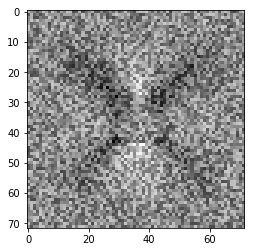

In [13]:
plt.imshow(triangle_weights.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

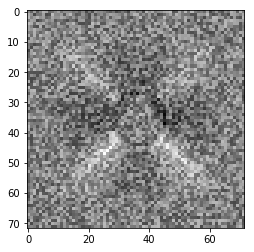

In [14]:
plt.imshow(rectangle_weights.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

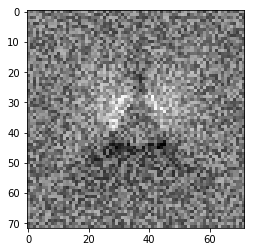

In [15]:
plt.imshow(disk_weights.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## A more difficult classification problem

In [16]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:



Creating data:


We convert again our class id in one hot vectors

In [17]:
Y_train = np_utils.to_categorical(Y_train)

We reuse the classifier trained on Adam. We will use model.evaluate(X_test, Y_test) later, but we will also compute the validation score along the epochs by adding a validation_data option to our fit method.

First, we reinitialize weights and compile the model again. To reinitialize weights, we simply reinstanciate the model.

In [18]:
# reinitialize weights
model = Sequential([
    Dense(nb_classes, input_shape=((X_train.shape[1],)),activation="softmax")
])

# compile again
model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=["accuracy"]
)

In [19]:
model.fit(X_train, Y_train_bis, 
          validation_data=(X_test, Y_test),
          epochs=20, batch_size=32, verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 0s - loss: 3.0327 - acc: 0.3733 - val_loss: 3.4837 - val_acc: 0.3300
Epoch 2/20
300/300 [==============================] - 0s - loss: 1.9565 - acc: 0.3733 - val_loss: 1.3644 - val_acc: 0.3367
Epoch 3/20
300/300 [==============================] - 0s - loss: 1.4924 - acc: 0.3600 - val_loss: 1.2971 - val_acc: 0.3133
Epoch 4/20
300/300 [==============================] - 0s - loss: 1.2770 - acc: 0.3633 - val_loss: 1.8896 - val_acc: 0.3400
Epoch 5/20
300/300 [==============================] - 0s - loss: 1.8169 - acc: 0.3333 - val_loss: 1.8350 - val_acc: 0.3300
Epoch 6/20
300/300 [==============================] - 0s - loss: 1.2200 - acc: 0.4033 - val_loss: 1.1767 - val_acc: 0.4000
Epoch 7/20
300/300 [==============================] - 0s - loss: 1.1171 - acc: 0.4600 - val_loss: 1.2279 - val_acc: 0.3800
Epoch 8/20
300/300 [==============================] - 0s - loss: 1.1473 - acc: 0.4433 - val_l

We notice that classifier is less efficient on more complex data. Indeed, the model is not sufficient to explain the diversity of the data. That's why we need to build a deeper network.

In [20]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Reshape

cnn = Sequential([
    Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(X_train.shape[1],)),
    Conv2D(16, 5, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(3, activation="softmax"),
])

cnn.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=["accuracy"]
)

In [21]:
cnn.fit(X_train, Y_train, 
          validation_data=(X_test, Y_test),
          epochs=30, batch_size=32, verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/30
300/300 [==============================] - 1s - loss: 1.6814 - acc: 0.3700 - val_loss: 0.9802 - val_acc: 0.5233
Epoch 2/30
300/300 [==============================] - 1s - loss: 0.8573 - acc: 0.6400 - val_loss: 0.9231 - val_acc: 0.5133
Epoch 3/30
300/300 [==============================] - 1s - loss: 0.7136 - acc: 0.7500 - val_loss: 0.8232 - val_acc: 0.6100
Epoch 4/30
300/300 [==============================] - 1s - loss: 0.5805 - acc: 0.8267 - val_loss: 0.8184 - val_acc: 0.6233
Epoch 5/30
300/300 [==============================] - 1s - loss: 0.4719 - acc: 0.8233 - val_loss: 0.7838 - val_acc: 0.6233
Epoch 6/30
300/300 [==============================] - 1s - loss: 0.4267 - acc: 0.8533 - val_loss: 0.8049 - val_acc: 0.6233
Epoch 7/30
300/300 [==============================] - 1s - loss: 0.3688 - acc: 0.8900 - val_loss: 0.8368 - val_acc: 0.6067
Epoch 8/30
300/300 [==============================] - 1s - loss: 0.3234 - acc: 0.9033 - val_l

The training accuracy is way better with a CNN, but we still have overfitting. We can try to reduce it by making the network deeper and by adding dropout for regularization:

In [22]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Reshape, Dropout

cnn = Sequential([
    Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(X_train.shape[1],)),
    Conv2D(16, 5, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(16, 5, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(16384, activation="relu"),
    Dense(3, activation="softmax"),
])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

cnn.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=["accuracy"]
)

In [23]:
cnn.fit(X_train, Y_train, 
          validation_data=(X_test, Y_test),
          epochs=40, batch_size=32, verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/40
300/300 [==============================] - 3s - loss: 1.0967 - acc: 0.3633 - val_loss: 1.1076 - val_acc: 0.3300
Epoch 2/40
300/300 [==============================] - 2s - loss: 1.0694 - acc: 0.4033 - val_loss: 1.0173 - val_acc: 0.5167
Epoch 3/40
300/300 [==============================] - 2s - loss: 0.9817 - acc: 0.5533 - val_loss: 0.8653 - val_acc: 0.6400
Epoch 4/40
300/300 [==============================] - 2s - loss: 0.7167 - acc: 0.7467 - val_loss: 0.5879 - val_acc: 0.7567
Epoch 5/40
300/300 [==============================] - 2s - loss: 0.4322 - acc: 0.8333 - val_loss: 0.5365 - val_acc: 0.8000
Epoch 6/40
300/300 [==============================] - 2s - loss: 0.3531 - acc: 0.8467 - val_loss: 0.4771 - val_acc: 0.8133
Epoch 7/40
300/300 [==============================] - 2s - loss: 0.2588 - acc: 0.9000 - val_loss: 0.4289 - val_acc: 0.8600
Epoch 8/40
300/300 [==============================] - 2s - loss: 0.1867 - acc: 0.9400 - val_l

With a more complex architecture and dropout, we have far better results. As shown during the training and with the evaluate method:

In [24]:
cnn.evaluate(X_test, Y_test)

288/300 [===========================>..] - ETA: 0s

[0.2786359592278798, 0.9466666674613953]

## Regression

In [62]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:



Creating data:


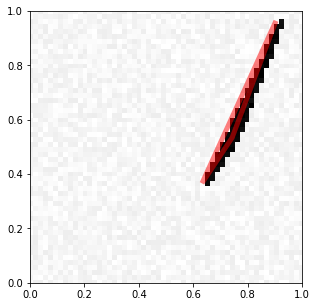

In [63]:
visualize_prediction(X_train[0], Y_train2[0])

To improve our results, we could normalize our data. We could also sort the vertices clockwise. But sorting them by x-coordinate was more arbitrary and however efficient.

In [134]:
def ordinateX(x):
    liste = [
        [x[0], x[1]],
        [x[2], x[3]],
        [x[4], x[5]]
    ]
    liste.sort(key=lambda x: x[0])
    res = []
    for elt in liste:
        res.append(elt[0])
        res.append(elt[1])
    return np.array(res)

In [141]:
Y_train = np.array([ordinateX(Y_train2[i]) for i in range(Y_train2.shape[0])])
Y_test = np.array([ordinateX(Y_test2[i]) for i in range(Y_test2.shape[0])])

In [158]:
regressor = Sequential([
    Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(X_train.shape[1],)),
    Conv2D(16, 5, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(16, 3, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(6, activation="sigmoid"),
])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

regressor.compile(
    loss='mean_squared_error', 
    optimizer=adam, 
    metrics=["mse"]
)

In [159]:
regressor.fit(X_train, Y_train, 
          validation_data=(X_test, Y_test),
          epochs=40, batch_size=32, verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/40
300/300 [==============================] - 3s - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 2/40
300/300 [==============================] - 2s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 3/40
300/300 [==============================] - 2s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0401 - val_mean_squared_error: 0.0401
Epoch 4/40
300/300 [==============================] - 2s - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 5/40
300/300 [==============================] - 1s - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 6/40
300/300 [==============================] - 1s - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 7/40
300/300 [================

In [163]:
res = regressor.predict(X_test)
res_train = regressor.predict(X_train)

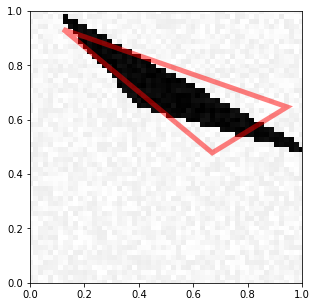

In [165]:
visualize_prediction(X_test[6],res[6])

We notice that the regression performs well on the training set (with a Mean Squared error close to zero). But the regressor is strongly overfitted. I could try with a larger dataset or with another architecture, but I hadn't the time to do it.

## Image denoising

In [177]:
def generate_a_drawing_denoising(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata2 = imdata + noise * np.random.random() * np.random.random(imdata.size)
    plt.close(fig)
    return imdata2, imdata

def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_denoising(figsize, U, V, noise)


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_denoising(figsize, U, V, noise)

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing_denoising(figsize, U, V, noise)

In [178]:
def generate_dataset_denoising(nb_samples, noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in tqdm_notebook(range(nb_samples)):
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_denoising(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_denoising(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20, True)
    return [X_test, Y_test]



In [184]:
[X_train_denoising, Y_train_denoising] = generate_dataset_denoising(300, 20)
[X_test_denoising, Y_test_denoising] = generate_test_set_denoising()

Creating data:



Creating data:


We use a U-Net architecture truncated such that it fits the image sizes.

In [281]:
from keras.layers.merge import Concatenate

inputs= Input(shape=((IMAGE_SIZE * IMAGE_SIZE,)))
reshape = Reshape((IMAGE_SIZE, IMAGE_SIZE, 1))(inputs)

conv1a = Conv2D(64, 3, activation="relu", padding="same")(reshape)
conv1b = Conv2D(64, 3, activation="relu", padding="same")(conv1a)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1b)

conv2a = Conv2D(128, 3, activation="relu", padding="same")(pool1)
conv2b = Conv2D(128, 3, activation="relu", padding="same")(conv2a)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2b)

up1 = UpSampling2D(size=(2,2))(pool2)
up_conv1a = Conv2D(256, 2, activation="relu", padding="same")(up1)
up_conv1b = Conv2D(256, 3, activation="relu", padding="same")(up_conv1a)
up_conv1c = Conv2D(256, 3, activation="relu", padding="same")(up_conv1b)

up2 = UpSampling2D(size=(2,2))(up_conv1c)
up_conv2a = Conv2D(128, 2, activation="relu", padding="same")(up2)
merge1 = Concatenate(axis=3)([conv1b, up_conv2a])
up_conv2b = Conv2D(128, 3, activation="relu", padding="same")(up_conv2a)
up_conv2c = Conv2D(128, 3, activation="relu", padding="same")(up_conv2b)

end_conv = Conv2D(1, 1, activation="sigmoid")(up_conv2c)
end_reshape = Reshape((IMAGE_SIZE*IMAGE_SIZE,))(end_conv)

autoencoder = Model(inputs, end_reshape)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=adam
)

In [283]:
autoencoder.fit(X_train_denoising, Y_train_denoising,
               epochs=5, batch_size=32, verbose=1)

Epoch 1/5
300/300 [==============================] - 304s - loss: -3683.3377    
Epoch 2/5
300/300 [==============================] - 262s - loss: -3684.0057    
Epoch 3/5
300/300 [==============================] - 256s - loss: -3684.0057    
Epoch 4/5
192/300 [==================>...........] - ETA: 98s - loss: -3684.4921 

KeyboardInterrupt: 

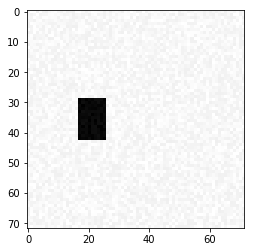

In [284]:
plt.imshow(X_train_denoising[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

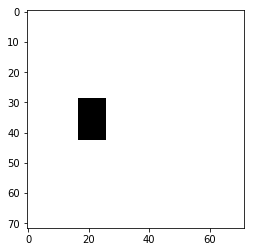

In [285]:
plt.imshow(Y_train_denoising[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

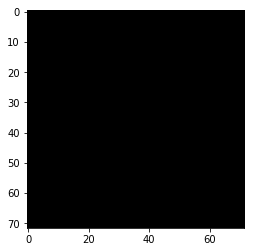

In [287]:
plt.imshow((autoencoder.predict(np.array([X_train_denoising[0]]))).reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

The estimator has fallen into a local minima that makes pictures completely black. I wasn't able to find the global minimum.